In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torchlake.image_generation.controllers.trainer_pixelcnn import PixelCNNTrainer
from torchlake.image_generation.controllers.predictor_pixelcnn import PixelCNNPredictor
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_num_workers
from torchlake.image_generation.models.pixelcnn import PixelCNN
from torchvision import transforms

# Setting

In [2]:
IMAGE_SIZE = 28
BATCH_SIZE = 128

In [3]:
artifact_path = Path("../../artifacts/pixelcnn")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/mnist")

In [4]:
DEVICE = torch.device("cuda:0")

# Data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [6]:
train_data = torchvision.datasets.MNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

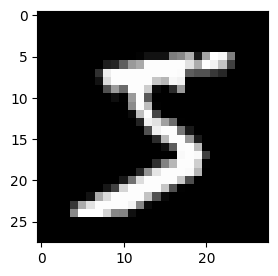

In [7]:
plt.figure(figsize=(3, 3))
plt.imshow(img_tensor_to_np(train_data[0][0]), cmap="gray")

In [8]:
def collate_fn(batch):
    x, y = [], []
    for img, _ in batch:
        x.append(img)
        y.append(img)
        
    return torch.stack(x), torch.stack(y).mul_(255).long().view(-1, IMAGE_SIZE, IMAGE_SIZE)

In [9]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=collate_fn,
    num_workers=get_num_workers(),
)

In [10]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28]) torch.Size([128, 28, 28])


# Model

In [11]:
model = PixelCNN(
    1,
    256,
    hidden_dim=128,
    num_layer=12,
).to(DEVICE)

In [12]:
import torchinfo

torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
PixelCNN                                 --
├─Sequential: 1-1                        --
│    └─MaskedConv2d: 2-1                 12,800
├─Sequential: 1-2                        --
│    └─ResBlock: 2-2                     --
│    │    └─ReLU: 3-1                    --
│    │    └─BottleNeck: 3-2              213,504
│    │    └─Identity: 3-3                --
│    └─ResBlock: 2-3                     --
│    │    └─ReLU: 3-4                    --
│    │    └─BottleNeck: 3-5              213,504
│    │    └─Identity: 3-6                --
│    └─ResBlock: 2-4                     --
│    │    └─ReLU: 3-7                    --
│    │    └─BottleNeck: 3-8              213,504
│    │    └─Identity: 3-9                --
│    └─ResBlock: 2-5                     --
│    │    └─ReLU: 3-10                   --
│    │    └─BottleNeck: 3-11             213,504
│    │    └─Identity: 3-12               --
│    └─ResBlock: 2-6                     --
│  

# train

In [13]:
EPOCH = 10

In [14]:
trainer = PixelCNNTrainer(EPOCH, DEVICE)

In [15]:
trainer.recorder.increment_data_size(len(train_data))

In [16]:
criterion = trainer.get_criterion(256)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

In [17]:
scaler = torch.amp.grad_scaler.GradScaler()

In [18]:
training_loss = trainer.run(train_loader, model, optim, criterion, scaler=None)

Enable AMP: False
Training...


100%|██████████| 468/468 [01:28<00:00,  5.27it/s]


------------------------------------
Epoch 1
------------------------------------
total: 1.0327e-02 (0.00%)


100%|██████████| 468/468 [01:29<00:00,  5.23it/s]


------------------------------------
Epoch 2
------------------------------------
total: 6.4654e-03 (-37.00%)


100%|██████████| 468/468 [01:42<00:00,  4.57it/s]


------------------------------------
Epoch 3
------------------------------------
total: 6.3675e-03 (-2.00%)


100%|██████████| 468/468 [01:58<00:00,  3.95it/s]


------------------------------------
Epoch 4
------------------------------------
total: 6.2938e-03 (-1.00%)


100%|██████████| 468/468 [01:54<00:00,  4.07it/s]


------------------------------------
Epoch 5
------------------------------------
total: 6.2404e-03 (-1.00%)


100%|██████████| 468/468 [01:46<00:00,  4.38it/s]


------------------------------------
Epoch 6
------------------------------------
total: 6.2073e-03 (-1.00%)


100%|██████████| 468/468 [01:54<00:00,  4.09it/s]


------------------------------------
Epoch 7
------------------------------------
total: 6.1744e-03 (-1.00%)


100%|██████████| 468/468 [01:49<00:00,  4.29it/s]


------------------------------------
Epoch 8
------------------------------------
total: 6.1491e-03 (0.00%)


100%|██████████| 468/468 [01:53<00:00,  4.12it/s]


------------------------------------
Epoch 9
------------------------------------
total: 6.1288e-03 (0.00%)


100%|██████████| 468/468 [01:49<00:00,  4.26it/s]

------------------------------------
Epoch 10
------------------------------------
total: 6.1074e-03 (0.00%)


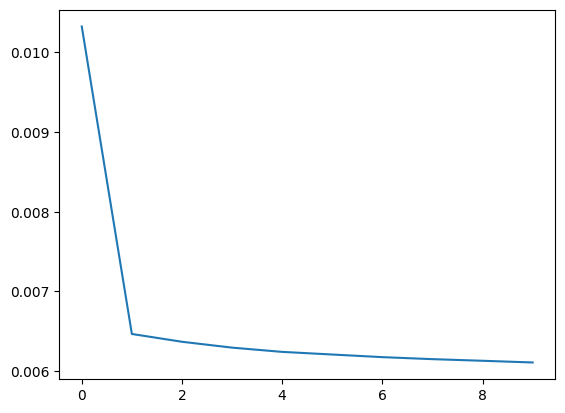

In [19]:
plt.plot(training_loss)

In [20]:
from torchlake.common.controller.weight_manager import WeightManager

manager = WeightManager(artifact_path.joinpath('pixelcnn.d{hidden_dim}.l{num_layer}.mnist.pth').as_posix())
model_path = manager.get_filename(hidden_dim=model.hidden_dim, num_layer=model.num_layer)

In [21]:
model_path

WindowsPath('../../artifacts/pixelcnn/pixelcnn.d128.l12.mnist.pth')

In [22]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\pixelcnn\pixelcnn.d128.l12.mnist.pth, model size is 10.17MiB


In [23]:
manager.load_weight(model_path, model)

# evaluation

In [24]:
TEST_BATCH_SIZE = 16

In [25]:
predictor = PixelCNNPredictor(DEVICE)

784it [00:05, 140.62it/s]


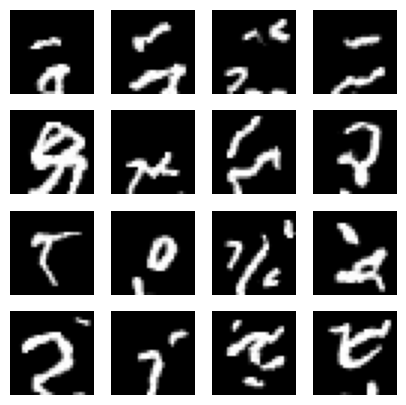

In [26]:
output = predictor.run(model, (TEST_BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE))

plot_grids(
    img_tensor_to_np(output), 
    cmap='gray',
    num_col=4,
    num_row=4,
    figsize=(5,5),
)